# IMAGEN Analysis #
First thing to do is read in the 'safe' training data file, which contains task and life history data. The model fit parameters will be read in after this.

In [1]:
# Read the training data file
fname  <- '/home/dan/documents/lncc/synthetic data/sst_round_2/safe_train_data.csv'
raw_df <- read.csv(file=fname, header=TRUE, sep=',');

# These fields don't need to go into analysis:
drop_flds <- c('Site_14'   , 'Group_14'      , 'Label_14_x', 'Label_14_y', 'Gender_14_x', 'Gender_14_y',
               'QR_flag_14', 'Reliability_16', '', 'espad_6.life.nic_14', 'espad_8a.alc.life_14', 
               'agn_mean_correct_latency_neutral_14', 'agn_total_omissions_neutral_14')

# Drop them:
raw_df <- raw_df[,!(names(raw_df) %in% drop_flds)]

# Convert Age_14 data to days
# Don't know exact conversion since don't know years, but this is fine
raw_df['Age_14'] = raw_df['Age_14']*365.24

# Measures that exist for age 16: Currently not being used.
features_16 <- c('Age.for.timestamp_16', 'X6.life.nic_16', 'X8a.life.alc_16', 'life_amphet_16', 'life_anabolic_16',
    'life_coke_16', 'life_crack_16', 'life_ghb_16', 'life_glue_16', 'life_hash_16', 'life_heroin_16',
    'life_ketamine_16', 'life_lsd_16', 'life_mdma_16', 'life_mushrooms_16', 'life_tranq_16', 'log10.k._16')

The model-fit parameters get read in here for the SST and MID tasks.

In [2]:
# Read the SST parameters' file:
sst_params_file  <- '/home/dan/documents/lncc/sst_data_train/parameters1.csv'
sst_params_raw   <- read.csv(file=sst_params_file, header=TRUE, sep=';');

# What parameters are being reaD?
sst_params_names <- c('mu_go_subj' ,'mu_stop_subj' ,'sigma_go_subj', 'sigma_stop_subj',
                      'tau_go_subj','tau_stop_subj','p_tf_subjpt')

# Set up the dataframe to accept mean parameter values.
sst_params           <- data.frame(matrix(ncol=7, nrow=198))
colnames(sst_params) <- sst_params_names 
trace_means          <- colMeans(sst_params_raw)
sst_params['Subject']<- raw_df['Subject']

# Save the parameters:
for (subj_num in 1:198) {
    for (param_name in sst_params_names) {
        
        param_name_long <- paste(param_name,'.',subj_num, sep='')

        # Currently missing some data...
        if (any(subj_num == 157:185)) {            
        } else{
            sst_params[subj_num, param_name] <- trace_means[param_name_long]
        }
    }
}

# Read the MID fit file in:
mid_params_file <- '/home/dan/documents/lncc/From Nick Jan 20/MIDT_SubjectFits_BL_All.csv'
mid_params_raw  <- read.csv(file=mid_params_file, header=TRUE, sep=',');

#
mid_params       <- data.frame(matrix(ncol=12, nrow=dim(unique(mid_params_raw['Subject']))[1]))
mid_params_names <- c('Target Duration Coeff', 'Target is Left Coeff', 'Cue is Rewarded Coeff',
                      'Cue is High Reward Coeff', 'StDev of 1/RT', 'Intercept')
mid_params_type  <- c('Expectation', 'Variance')

colnames(mid_params) <- c( outer( mid_params_names, c('Expectation', 'Variance'), FUN=paste ,sep=" "))

mid_params['Subject'] <- unique(mid_params_raw['Subject'])
for (row in  1:dim(mid_params_raw)[1]) {
    subject <- mid_params_raw[row, 'Subject']
    param   <- mid_params_raw[row, 'Parameter']
    
    subj_msk <- mid_params['Subject'] == subject
        
    mid_params[subj_msk, paste(param,'Expectation',sep=' ')] <- mid_params_raw[row,'Expectation']
    mid_params[subj_msk, paste(param,'Variance'   ,sep=' ')] <- mid_params_raw[row,'Variance'   ]
}
tmp <- merge(sst_params, mid_params, by="Subject")

#print(dim(raw_df)[1])
raw_df <- merge(raw_df, tmp, by="Subject", all=TRUE)
raw_df_backup <- raw_df
#print(dim(raw_df)[1])

Specific subsets of the features available get selected here for use.

In [3]:
# Task data at age 14:
features_14_task_raw <- c('IQ_PR_14', 'IQ_VC_14', 'GB_SSRT_14',
       'agn_mean_correct_latency_negative_14',
       'agn_mean_correct_latency_positive_14',
       'agn_total_omissions_negative_14',
       'agn_total_omissions_positive_14',
       'cgt_delay_aversion_14',
       'cgt_deliberation_time_14',
       'cgt_quality_of_decision_making_14',
       'cgt_overall_proportion_bet_14',
       'cgt_risk_adjustment_14',
       'cgt_risk_taking_14',
       'prm_percent_correct_14',
       'rvp_a_14',
       'swm_between_errors_14',
       'swm_strategy_14',
       'log10.k._14', sst_params_names, colnames(mid_params))

features_14_task <- c('IQ_PR_14', 'IQ_VC_14', 'GB_SSRT_14',
       'agn_mean_cor_lat_neg_14',
       'agn_mean_cor_lat_pos_14',
       'agn_num_omis_neg_14',
       'agn_num_omis_pos_14',
       'cgt_delay_avers_14',
       'cgt_deliberation_14',
       'cgt_quality_14',
       'cgt_prop_bet_14',
       'cgt_risk_adjust_14',
       'cgt_risk_taking_14',
       'prm_perc_cor_14',
       'rvp_a_14',
       'swm_btwn_errs_14',
       'swm_strategy_14',
       'log10.k._14',
       'mu_go_14', 'mu_stop_14', 'sigma_go_14','sigma_stop_14','tau_go_14','tau_stop_14','p_tf_14',
       'mu_targ_dur_co_14', 'mu_targ_left_co_14',  'mu_rewarded_co_14', 
       'mu_high_rewarded_co_14', 'mu_std_inv_rt_14', 'mu_int_14',
       'sig_targ_dur_co_14','sig_targ_left_co_14','sig_rewarded_co_14',
       'sig_high_rewarded_co_14','sig_std_inv_rt_14','sig_int_14')

# Survey data at age 14:
features_14_survey_raw <- c('Sex_best_M0_14', 'Age_14', 'PDS_14','All_Alc_14', 'All_Nic_14',
       'espad_life_amphet_14',
       'espad_life_anabolic_14',
       'espad_life_coke_14',
       'espad_life_crack_14',
       'espad_life_ghb_14',
       'espad_life_glue_14',
       'espad_life_hash_14',
       'espad_life_heroin_14',
       'espad_life_ketamine_14',
       'espad_life_lsd_14',
       'espad_life_mdma_14',
       'espad_life_mushrooms_14',
       'espad_life_narcotic_14',
       'espad_life_tranq_14')

features_14_survey <- c(
       'bio_sex_14' , 'age_14'      , 'pds_14'   ,
       'alc_14'     , 'nic_14'      , 'amphet_14',
       'anabolic_14', 'coke_14'     , 'crack_14' ,
       'ghb_14'     , 'glue_14'     , 'hash_14'  ,
       'heroin_14'  , 'ketamine_14' , 'lsd_14'   ,
       'mdma_14'    , 'mushrooms_14', 'narc_14'  ,
       'tranq_14')


# 
features_18_task <- c('log10.k._18', 'agn_mean_correct_latency_negative_18', 'agn_mean_correct_latency_neutral_18',
    'agn_mean_correct_latency_positive_18', 'agn_total_omissions_negative_18', 'agn_total_omissions_neutral_18',
    'agn_total_omissions_positive_18', 'cgt_delay_aversion_18', 'cgt_deliberation_time_18', 
    'cgt_overall_proportion_bet_18', 'cgt_quality_of_decision_making_18', 'cgt_risk_adjustment_18',
    'cgt_risk_taking_18', 'prm_percent_correct_18', 'rvp_a_18', 'swm_between_errors_18', 'swm_strategy_18')
    

features_18_survey <- c('age_18', 'X6.life.nic_18', 'X8a.life.alc_18', 'Life.amph_18', 'Life.anab_18',
    'Life.coke_18', 'Life.crack_18', 'Life.hash.thc_18', 'Life.heroin_18', 'Life.GHB_18', 'Life.glue_18', 
    'Life.ketamine_18', 'Life.lsd_18', 'Life.MDMA_18', 'Life.mushrooms_18', 'Lif.narc_18', 'Life.tranq_18')

n_feat_task   <- length(features_14_task)
n_feat_survey <- length(features_14_survey)

for (i in 1:n_feat_task){
    old_name <- features_14_task_raw[[i]]
    new_name <- features_14_task[[i]]
    colnames(raw_df)[colnames(raw_df) == old_name] <- new_name
}
for (i in 1:n_feat_survey){
    old_name <- features_14_survey_raw[[i]]
    new_name <- features_14_survey[[i]]
    names(raw_df)[names(raw_df) == old_name] <- new_name
}

In [4]:
# Take, for the moment, the case
raw_df <- raw_df[complete.cases(raw_df[,'mu_go_14']),]

## Summary Stats for MID and SST Params ##

No id variables; using all as measure variables
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 203 rows containing non-finite values (stat_bin).”

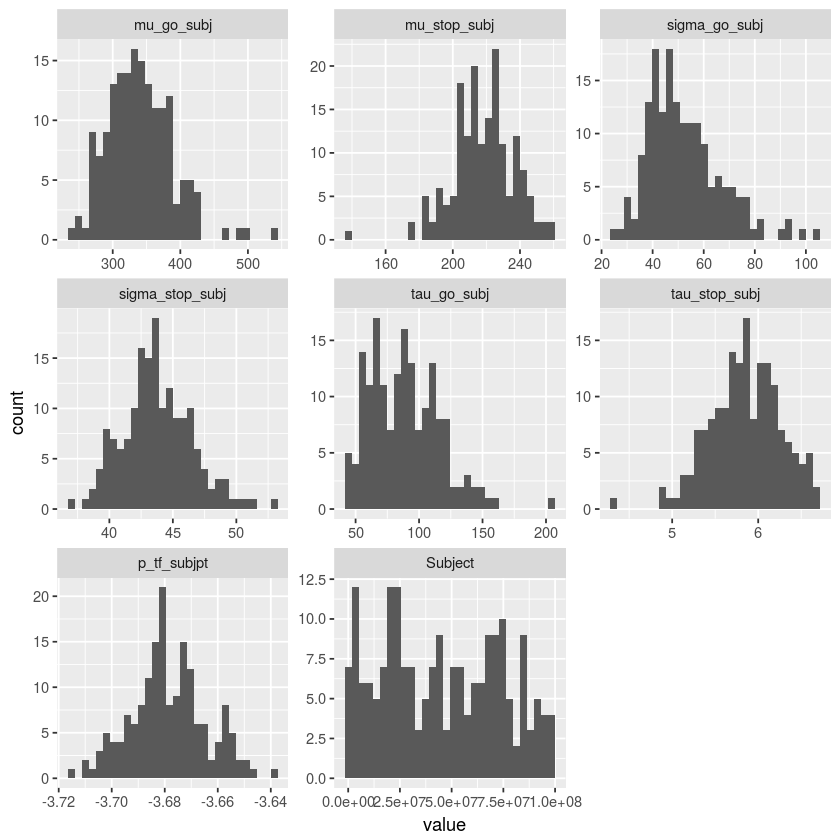

In [5]:
library(ggplot2)
library(reshape2)

d <- melt(sst_params)
ggplot(d, aes(x = value)) + facet_wrap(~variable, scales = "free") + geom_histogram()

## Mean Shift and Normalize ##

In [6]:
for (i in 1:n_feat_task){
    feature <- features_14_task[[i]]
    raw_df[feature] <- raw_df[feature] - colMeans(raw_df[feature], na.rm=TRUE)
    raw_df[feature] <- raw_df[feature] / apply(raw_df[feature], 2, sd, na.rm=TRUE)
}

raw_df['age_14'] <- raw_df['age_14'] - colMeans(raw_df['age_14'], na.rm=TRUE)
raw_df['age_14'] <- raw_df['age_14'] / apply(raw_df['age_14'], 2, sd, na.rm=TRUE)

raw_df['age_18'] <- raw_df['age_18'] - colMeans(raw_df['age_18'], na.rm=TRUE)
raw_df['age_18'] <- raw_df['age_18'] / apply(raw_df['age_18'], 2, sd, na.rm=TRUE)

## Further Data Subdivision ##
For the CCA we'll start by looking at how the task measures relate to the drug use survey...

In [7]:
# It also looks like some of the CANTAB data 
# has -1 values. Need to figure out what they are, but NA for now.
data_14_task.raw   <- raw_df[features_14_task]
data_14_survey.raw <- raw_df[features_14_survey]

data_18_task.raw   <- raw_df[features_18_task]
data_18_survey.raw <- raw_df[features_18_survey]

data_14_task.raw[data_14_task.raw == -1] <- NA
data_18_task.raw[data_18_task.raw == -1] <- NA

#write(       'Age 14 Task Statistics:'        , file = analysis_table_file, append = TRUE)
#write.table( summary(raw_df[features_14_task]), file = analysis_table_file, append = TRUE, sep=',')

#write(       'Age 14 Missing Task Data Pattern:' , file = analysis_table_file, append = TRUE)
#write.table( md.pattern(raw_df[features_14_task]), file = analysis_table_file, append = TRUE, sep = ',')

#write(       'nAge 14 Survey Statistics:'      , file = analysis_table_file, append = TRUE)
#write.table( summary(raw_df[features_14_survey]), file = analysis_table_file, append = TRUE, sep = ',')

#write(       'Age 14 Missing Survey Data Pattern:' , file = analysis_table_file, append = TRUE)
#write.table( md.pattern(raw_df[features_14_survey]), file = analysis_table_file, append = TRUE, sep = ',')

## Shuffle Test ##
For making sure that everything below this fails to find anything significant when all the data gets randomized.

## Missing Data: Age 14 ##

The missing data isn't uniformly distributed. Unfortunately, the output of md.pattern is a big table, which I can't figure out how to get displayed properly in Jupyter notebooks. But it gets created and saved below:

mice 2.25 2015-11-09


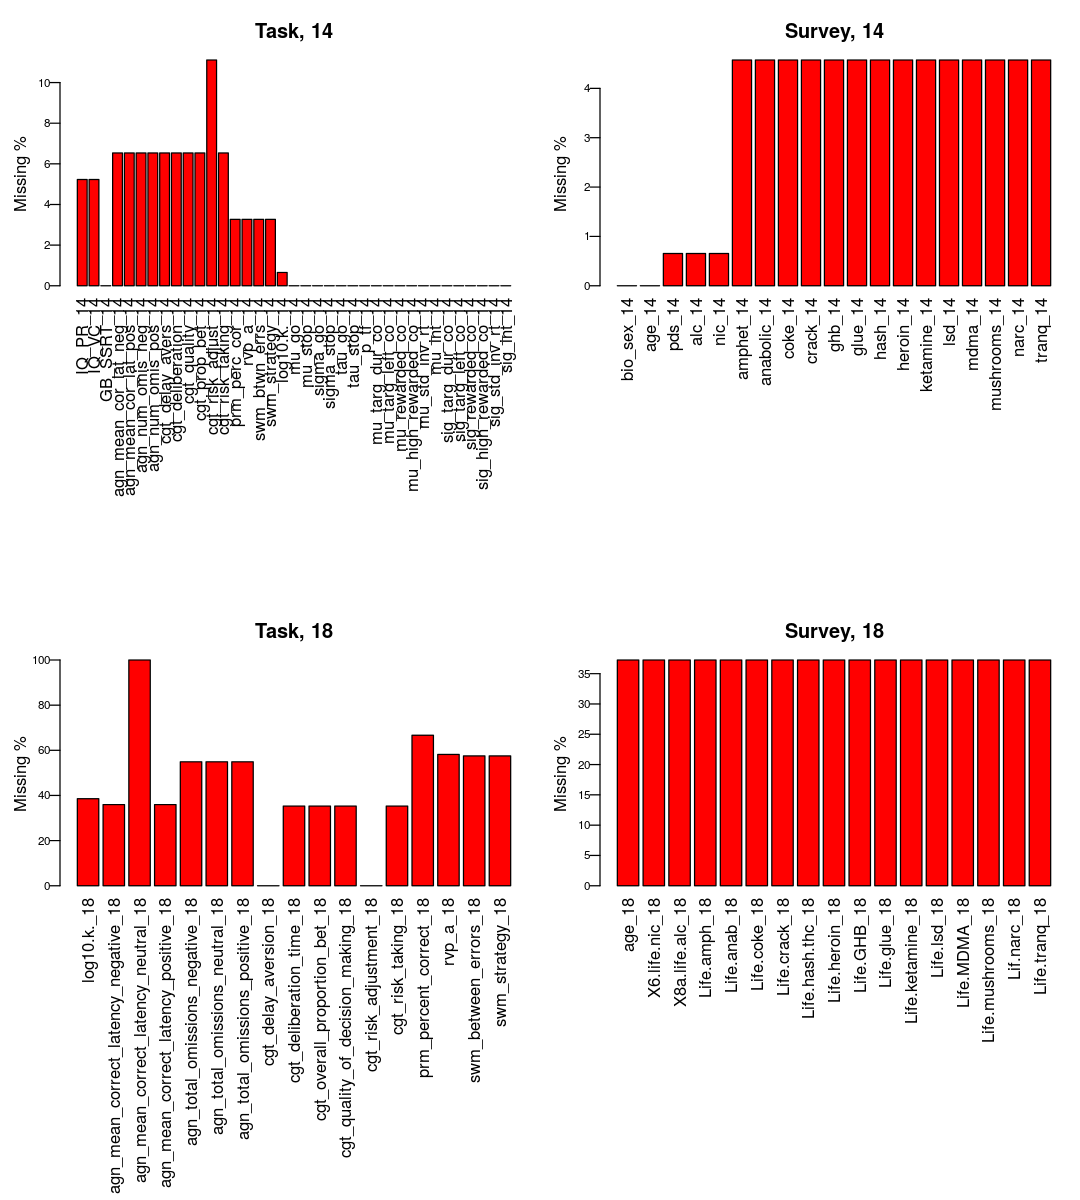

In [9]:
library(Rcpp)
library(mice)
missing_stats <- md.pattern(raw_df)

#analysis_table_file <- '/home/dan/documents/lncc/synthetic data/sst_round_2/analysis_tables.csv'
#write.csv(missing_stats, file = analysis_table_file)

get_missing_fracs <- function(data, ... ){
    result <- sapply(data, function(x) sum(is.na(x))) / dim(data)[1] * 100
    return(result)
}
                     
#options(repr.plot.width=7, repr.plot.height=7)

missing_tasks_14  <- get_missing_fracs(data_14_task.raw  )
missing_survey_14 <- get_missing_fracs(data_14_survey.raw)

missing_tasks_18  <- get_missing_fracs(data_18_task.raw  )
missing_survey_18 <- get_missing_fracs(data_18_survey.raw)

par(mfrow=c(2,2), mai = c(2.6, 0.5, 0.5, 0.1))
options(repr.plot.width=9, repr.plot.height=10)
#op <- par(mar = c(16,3,4,2))

barplot(missing_tasks_14 , col=c('red'), las=2, cex.axis=.7, ylab=c("Missing %"),  mgp=c(1.5,0.5,0), main='Task, 14')
barplot(missing_survey_14, col=c('red'), las=2, cex.axis=.7, ylab=c("Missing %"),  mgp=c(1.5,0.5,0), main='Survey, 14')
barplot(missing_tasks_18 , col=c('red'), las=2, cex.axis=.7, ylab=c("Missing %"),  mgp=c(1.5,0.5,0), main='Task, 18')
barplot(missing_survey_18, col=c('red'), las=2, cex.axis=.7, ylab=c("Missing %"),  mgp=c(1.5,0.5,0), main='Survey, 18')

## Impute Features: ##
... using an EM algorithm for the continuous data and mean imputation for categorical data.
<br /> <br />
This uses a naive EM implementation I found on R-bloggers, which should be fine for dealing with small numbers of subjects and has the benefit (to me) of transparency.
<br /> <br />
First, the algorithm definition:

In [10]:
EMalg <- function(x, tol=.001){
    missvals <- is.na(x)
    
    new.impute <- x
    old.impute <- x
    
    count.iter <- 1
    reach.tol  <- 0
    
    sig      <- as.matrix( var(   na.exclude(x) ))
    mean.vec <- as.matrix( apply( na.exclude(x),2,mean))
 
    while(reach.tol != 1) {
        for(i in 1:nrow(x)) {
            pick.miss <-( c( missvals[i,]) )

            if ( sum(pick.miss) != 0 ) {
                inv.S <- solve(sig[!pick.miss,!pick.miss]) # we need the inverse of the covariance
 
                # Run the EM
                new.impute[i,pick.miss] <- mean.vec[pick.miss] + sig[pick.miss,!pick.miss] %*% inv.S %*%
                    (t(new.impute[i,!pick.miss])- t(t(mean.vec[!pick.miss])))
            }
        }
 
        sig <- var((new.impute))
        mean.vec <- as.matrix(apply(new.impute,2,mean))

        if(count.iter > 1){ # we don't want this to run on the first iteration or else if fails
            for(l in 1:nrow(new.impute)){
                for(m in 1:ncol(new.impute)){
                    if( abs((old.impute[l,m]-new.impute[l,m])) > tol ) {
                        reach.tol <- 0
                    } else {
                        reach.tol <- 1
                    }
                }
            }
        }
 
        count.iter <- count.iter+1 # used for debugging purposes to ensure process it iterating properly
        old.impute <- new.impute
    }
 
    return(new.impute)
}

# Impute the task features:
data_14_task.imputed <- EMalg(data_14_task.raw, tol=.0001)

# Inverting a regression of alcohol and nicotine on the espad vars would be better...
# This shouldn't be too bad though.
library(splines)
library(foreach)
library(gam)

data_14_survey.imputed <- na.gam.replace(data_14_survey.raw)
data_14_survey.imputed <- round(data_14_survey.imputed)

Loaded gam 1.14



## Clean Up Features ##

In [11]:
# This code was for verifying the equivalence of the redundant alc and nic fields
#msk <- data_14_survey.raw['All_Nic_14'] == data_14_survey.raw['espad_6.life.nic_14']
#data_14_survey.raw[!msk,'All_Nic_14']


# Drop columns with all zeros, since they're uninformative.
data_14_survey.imputed <- data_14_survey.imputed[, colSums(data_14_survey.imputed != 0) > 0]

# Indicate which features are still a part of the data:
print('The following survey features were dropped:')
setdiff(features_14_survey, colnames(data_14_survey.imputed))

print('Hence, the following survey features are retained:')
print(colnames(data_14_survey.imputed))

n_feat_survey <- length(colnames(data_14_survey.imputed))
features_14_survey <- colnames(data_14_survey.imputed)

[1] "The following survey features were dropped:"


[1] "amphet_14"    "anabolic_14"  "coke_14"      "crack_14"     "ghb_14"      
 [6] "heroin_14"    "ketamine_14"  "lsd_14"       "mushrooms_14" "narc_14"

[1] "Hence, the following survey features are retained:"
[1] "bio_sex_14" "age_14"     "pds_14"     "alc_14"     "nic_14"    
[6] "glue_14"    "hash_14"    "mdma_14"    "tranq_14"  


No id variables; using all as measure variables
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


No id variables; using all as measure variables
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 144 rows containing non-finite values (stat_bin).”

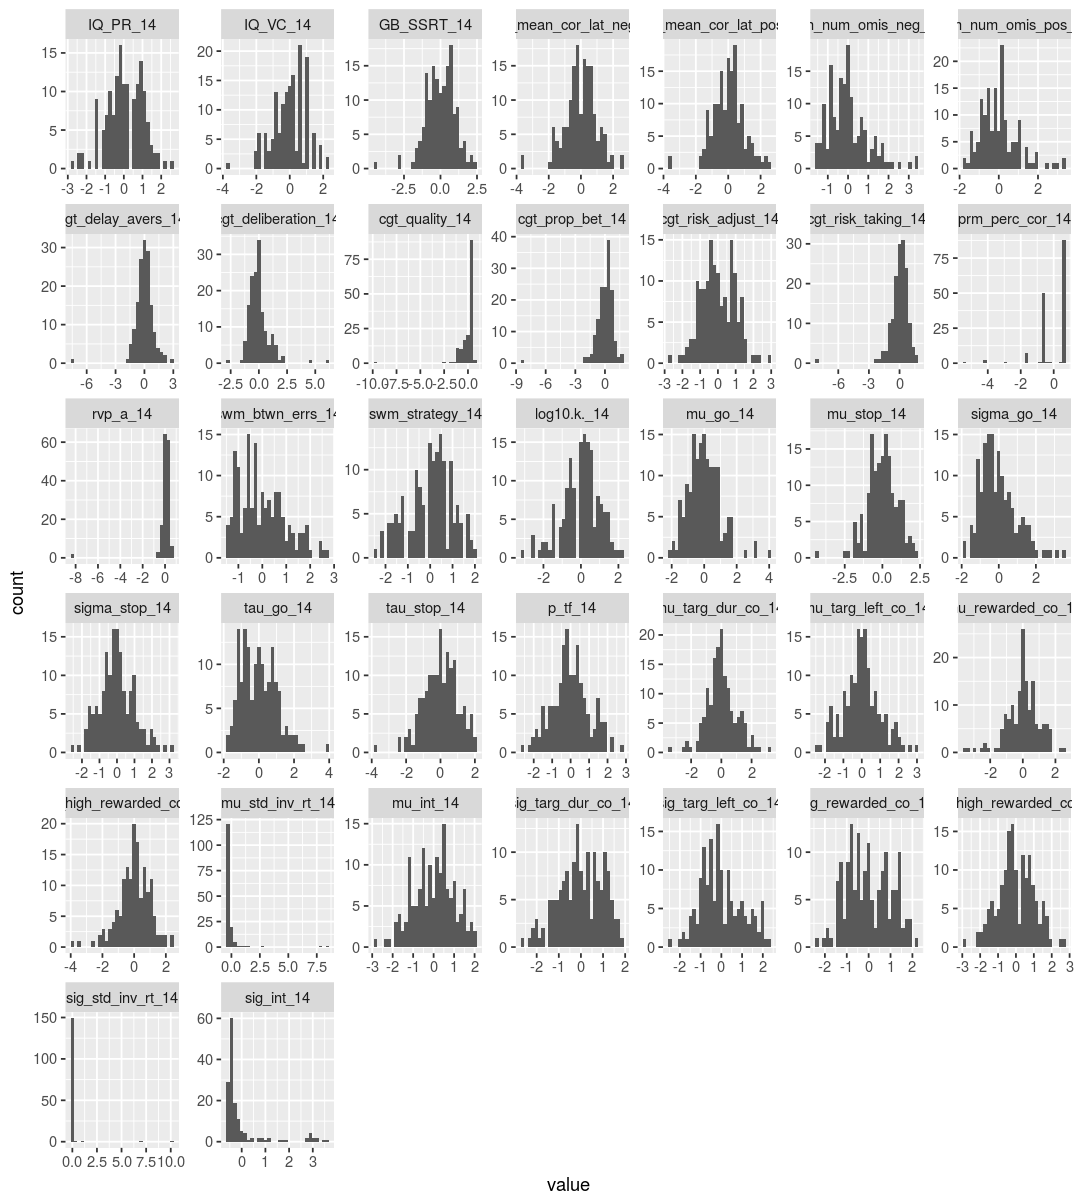

No id variables; using all as measure variables
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 101 rows containing non-finite values (stat_bin).”

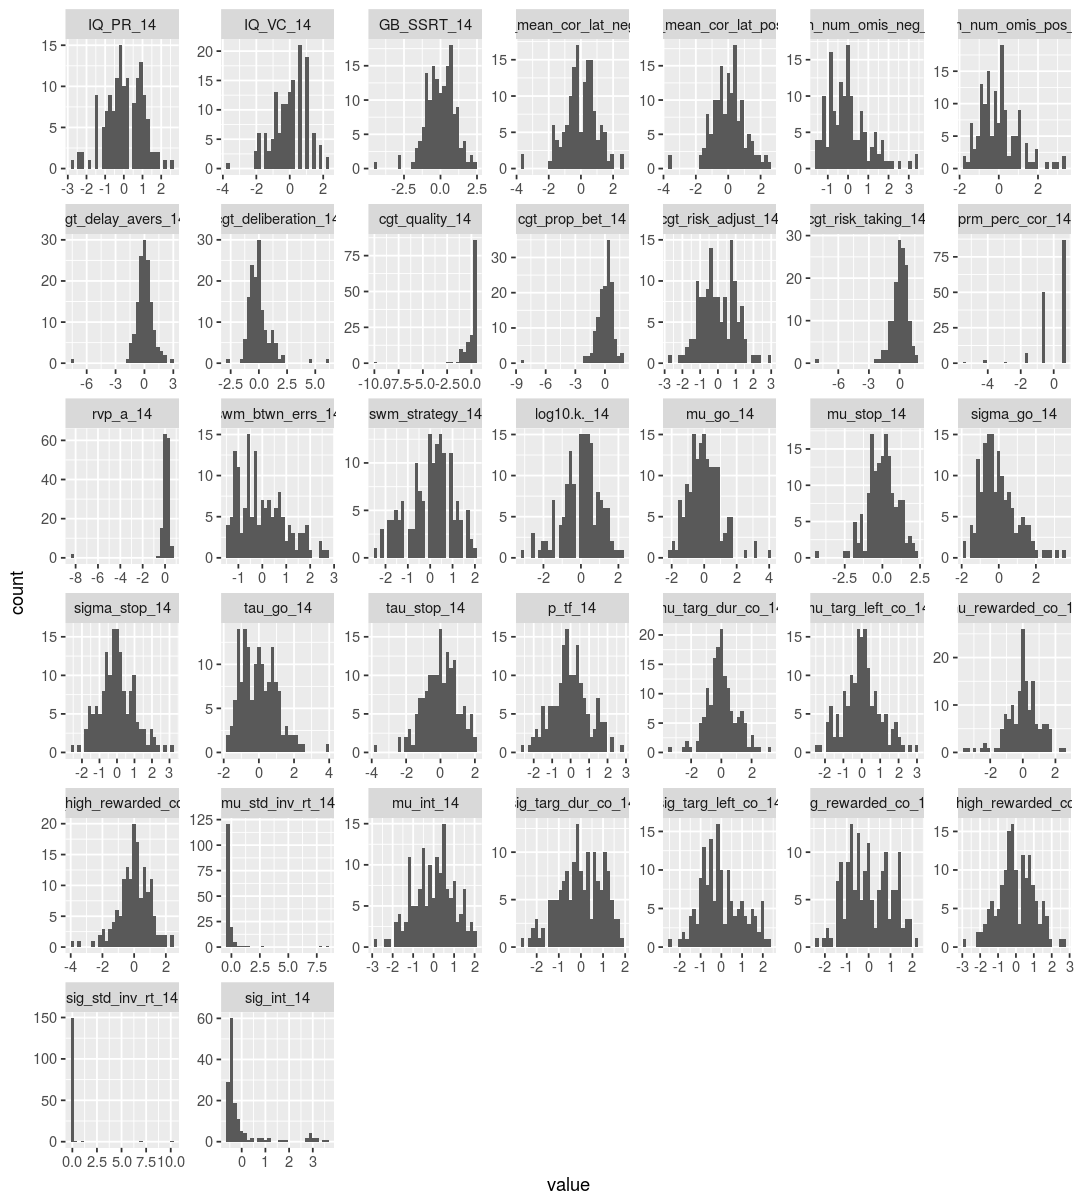

No id variables; using all as measure variables
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


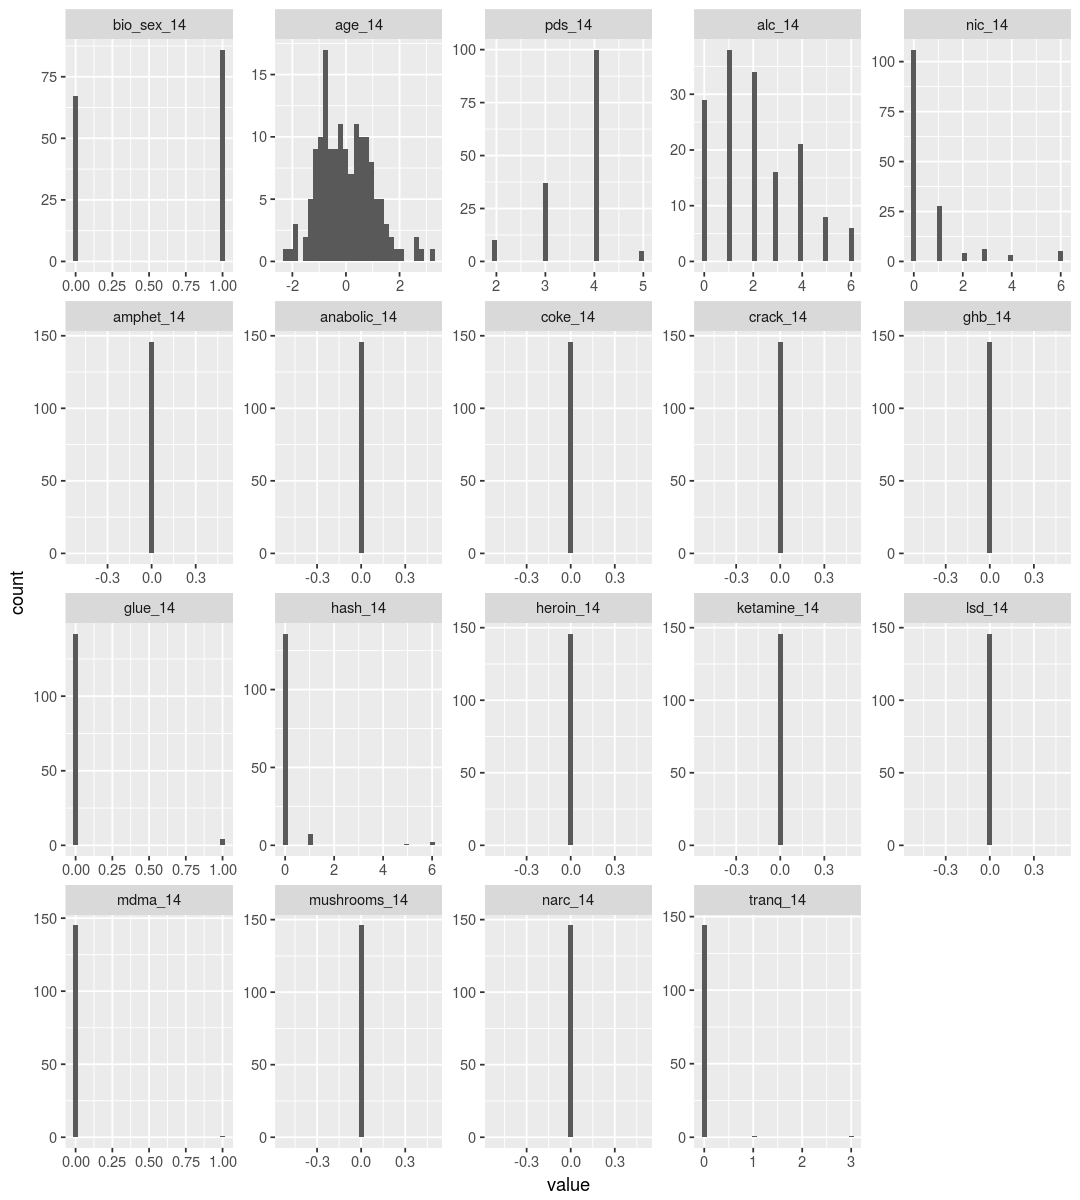

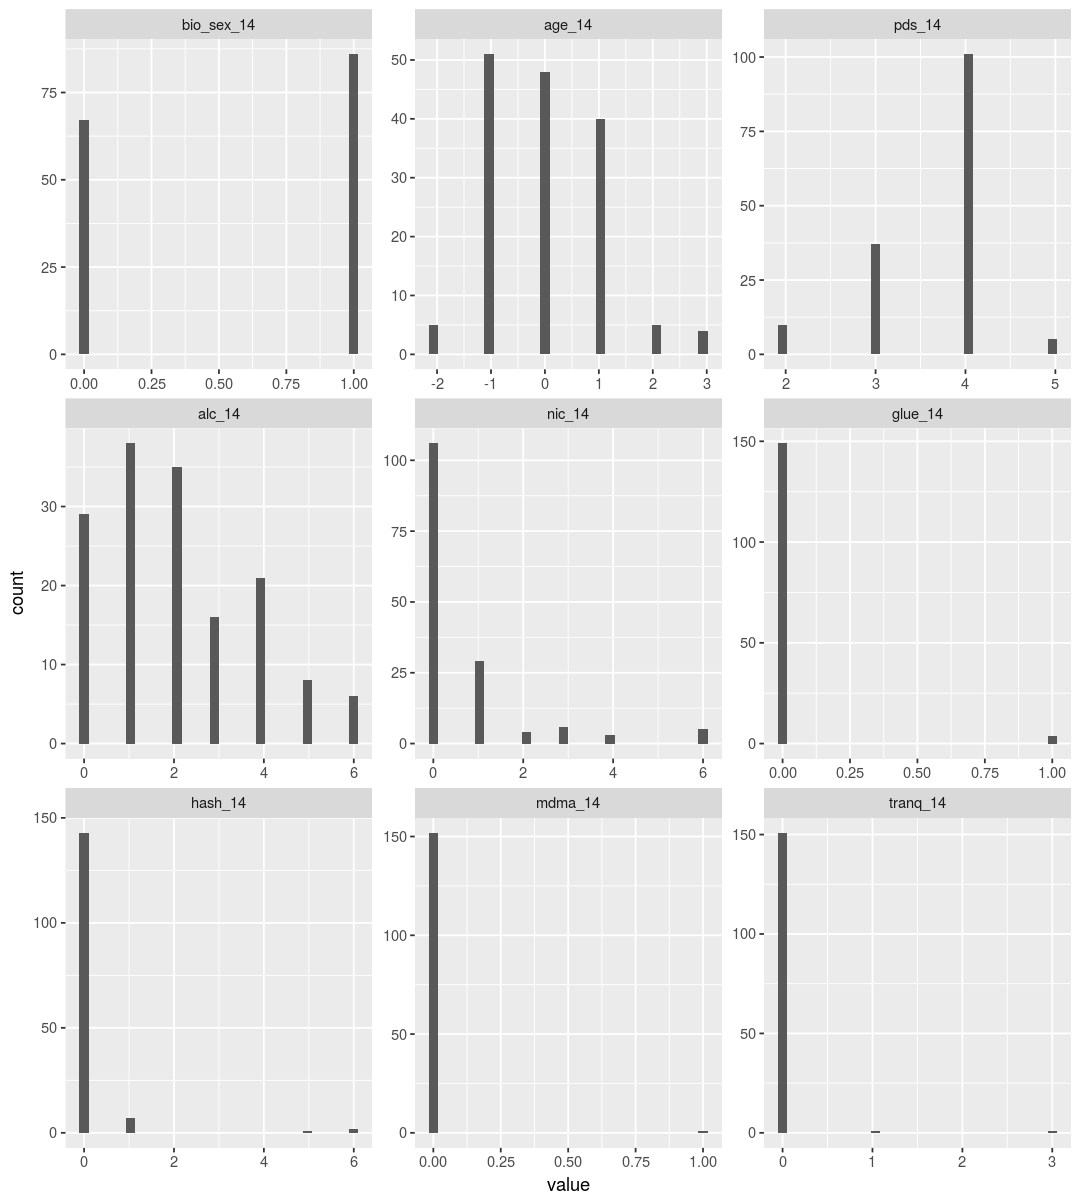

In [12]:
library(reshape2)
library(ggplot2)

d <- melt(data_14_task.imputed)
ggplot(d, aes(x = value)) + facet_wrap(~variable, scales = "free") + geom_histogram()

d <- melt(data_14_task.raw)
ggplot(d, aes(x = value)) + facet_wrap(~variable, scales = "free") + geom_histogram()

d <- melt(data_14_survey.raw)
ggplot(d, aes(x = value)) + facet_wrap(~variable, scales = "free") + geom_histogram()

d <- melt(data_14_survey.imputed)
ggplot(d, aes(x = value)) + facet_wrap(~variable, scales = "free") + geom_histogram()

## Misc. Correlations ##

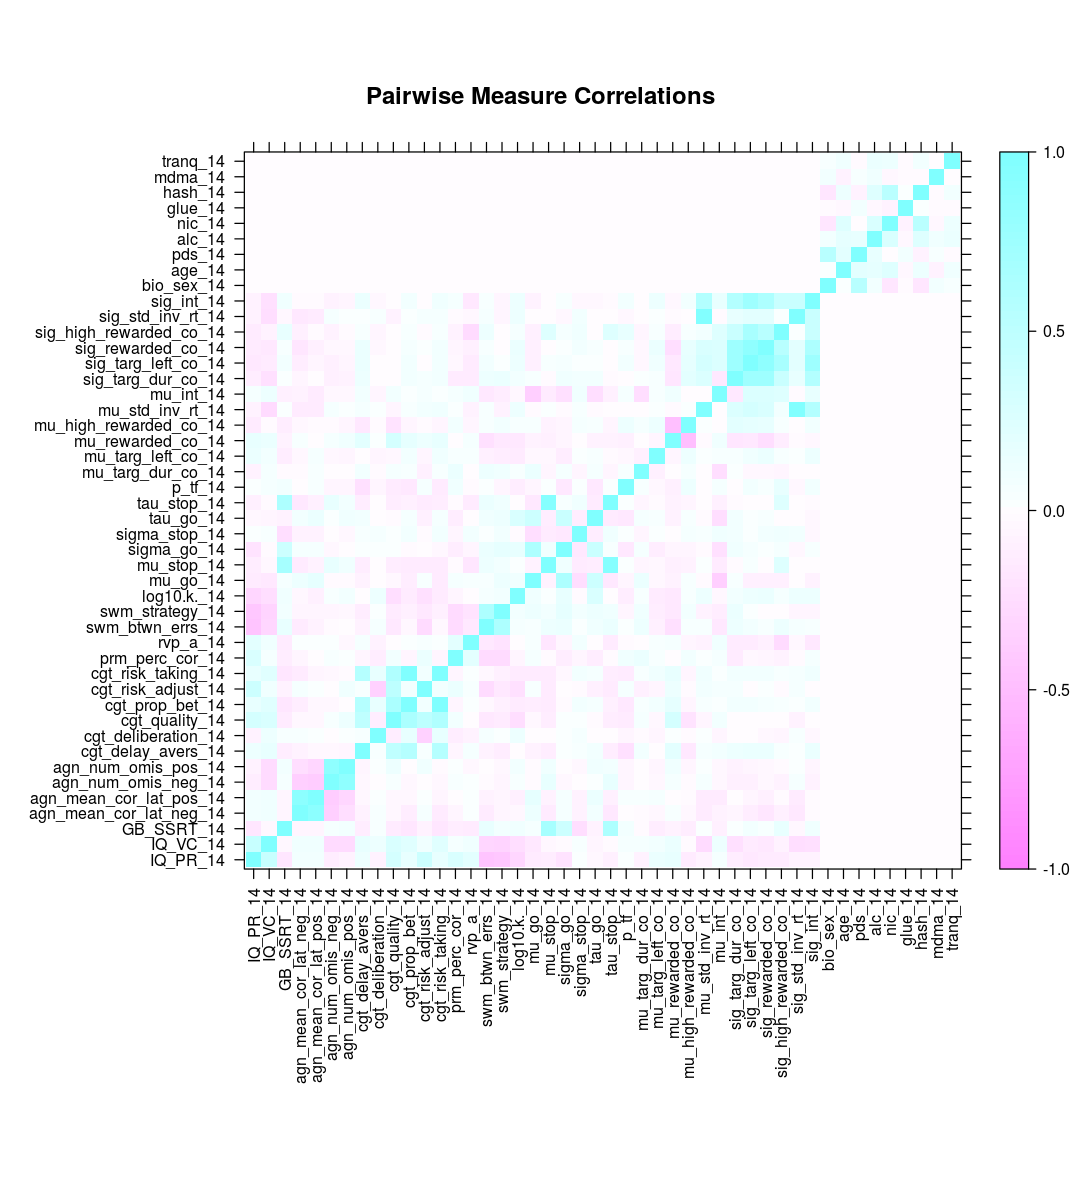

In [13]:
pairwise_correlations <- cor(merge(data_14_task.imputed,data_14_survey.imputed))

library(lattice)
scale <- list(x=list(rot=90))
#options(repr.plot.width=7.5, repr.plot.height=7.5)
levelplot(pairwise_correlations, scales=scale, main='Pairwise Measure Correlations'  , xlab = '', ylab = '',
         at=seq(-1, 1, length.out=100))
   #par.settings=RdBuTheme(), at=seq(-max(abs(cellStats(pairwise_correlatoins, range))),
   #                                  max(abs(cellStats(pairwise_correlations, range))), len=100))

## Canonical Correlations Analysis, Age 14 ##

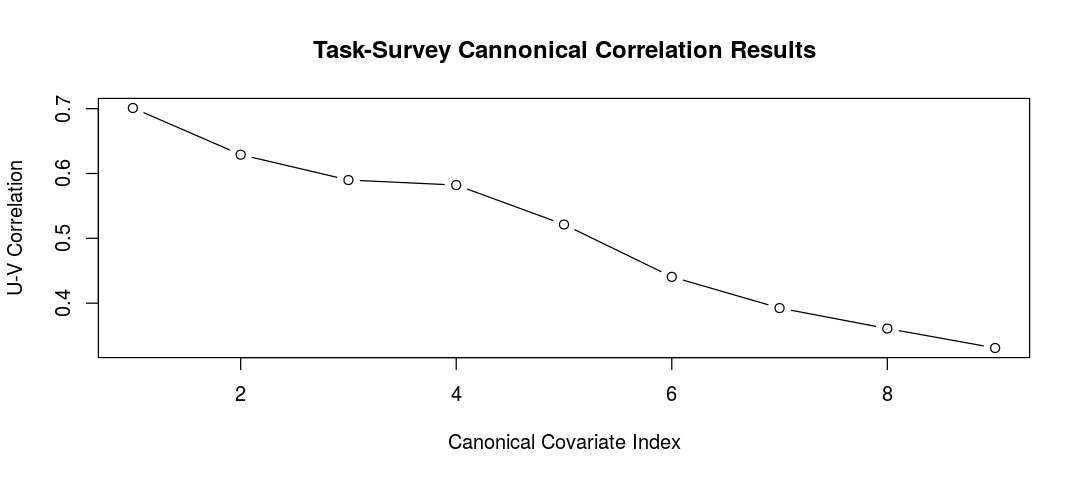

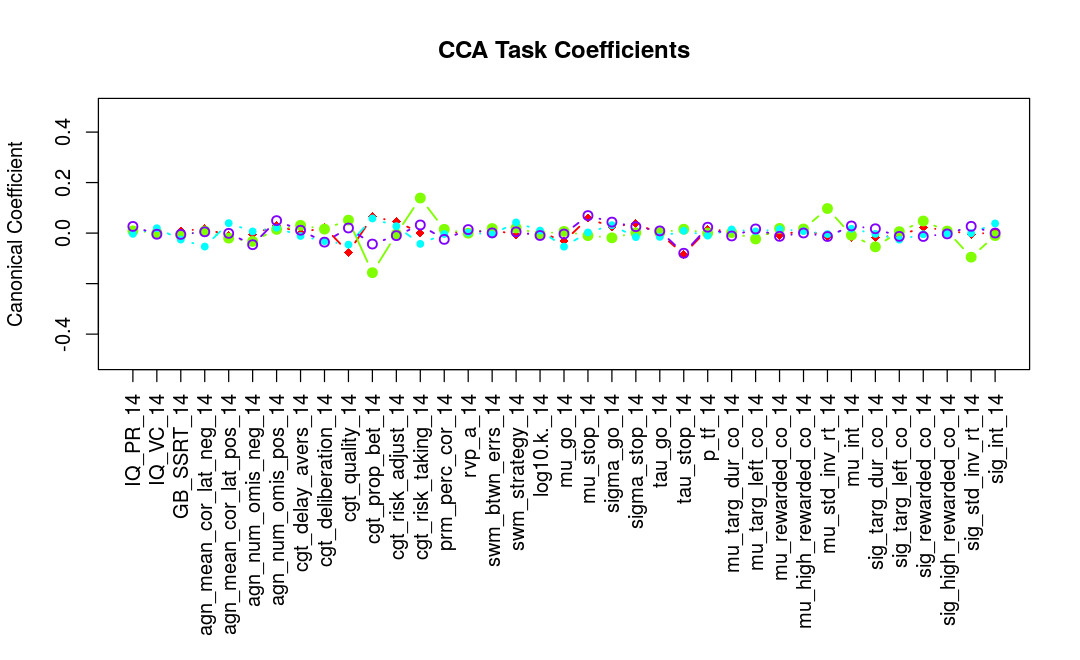

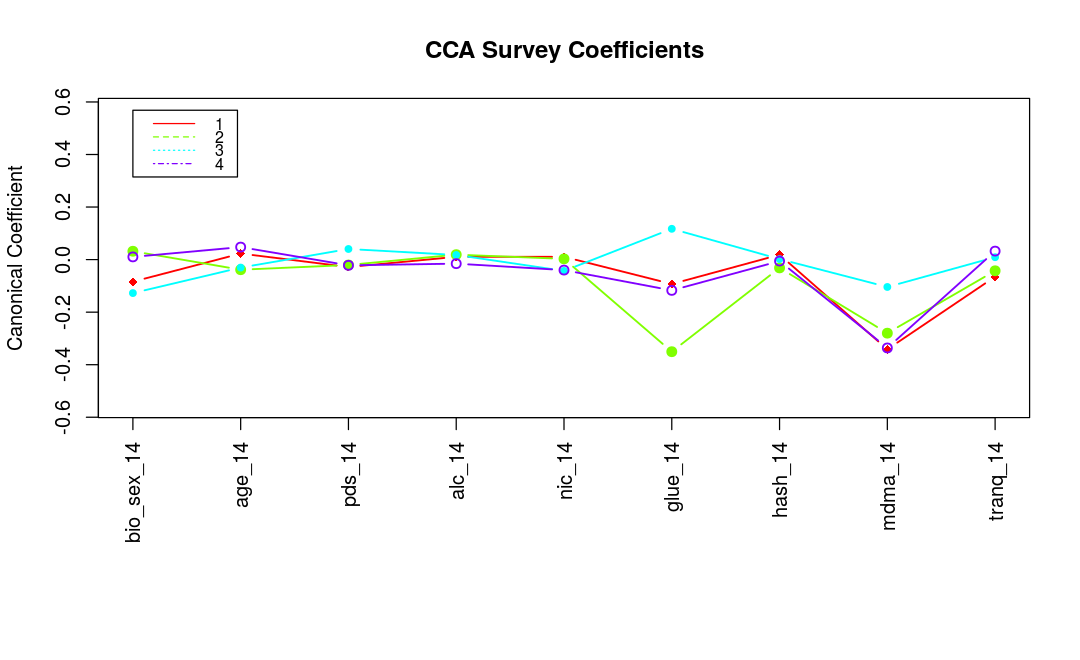

In [17]:
# Canonical Correlation Analysis:
library(CCA)
canon_corr_res = cancor(data_14_task.imputed, data_14_survey.imputed)

options(repr.plot.width=9, repr.plot.height=4)
plot(canon_corr_res$cor,type="b", main='Task-Survey Cannonical Correlation Results',
     xlab='Canonical Covariate Index', ylab='U-V Correlation')


nlines = 4
plotchar <- seq(18,18+nlines,1)

xrange <- range(1:n_feat_task) 
yrange <- range(canon_corr_res$xcoef)

op <- par(mar=c(12.1, 4.1, 4.1, 2.1))
#par(mfrow=c(2,1), mai = c(2.6, 0.5, 0.5, 0.1))
options(repr.plot.width=9, repr.plot.height=5.5)

plot(xrange, yrange, type="n", xlab="", ylab="Canonical Coefficient", xaxt="n") 

colors <- rainbow(nlines) 
linetype <- c(1:nlines) 
#plotchar <- seq(18,18+ntrees,1)

for (i in 1:nlines) { 
  lines(1:n_feat_task, canon_corr_res$xcoef[,i], type="b", lwd=1.5,
    lty=linetype[1], col=colors[i], pch=plotchar[i])
}

# add a title and subtitle 
title("CCA Task Coefficients")

# add a legend
legend(1, 50, 1:nlines, cex=0.8, col=colors, lty=linetype)
axis(1, labels=features_14_task, at=1:n_feat_task, las=2)



## CCA 
nlines = 4
plotchar <- seq(18,18+nlines,1)

xrange <- range(1:n_feat_survey) 
yrange <- range(canon_corr_res$ycoef)

op <- par(mar=c(10.1, 4.1, 4.1, 2.1))

plot(xrange, yrange, type="n", xlab="", ylab="Canonical Coefficient", xaxt="n") 

colors <- rainbow(nlines) 
linetype <- c(1:nlines) 
#plotchar <- seq(18,18+ntrees,1)

for (i in 1:nlines) { 
  lines(1:n_feat_survey, canon_corr_res$ycoef[,i], type="b", lwd=1.5, lty=linetype[1], col=colors[i], pch=plotchar[i])
}

# add a title and subtitle 
title("CCA Survey Coefficients")

# add a legend
legend(xrange[1], yrange[2], 1:nlines, cex=0.8, col=colors, lty=linetype)
axis(1, labels=features_14_survey, at=1:n_feat_survey, las=2)

In [15]:
# Significance testing:
library(CCP)
n_obs         <- dim(data_14_task.imputed)[1]
n_task_vars   <- dim(data_14_task.imputed)[2]
n_survey_vars <- dim(data_14_survey.imputed)[2]

p.asym(rho = canon_corr_res$cor, n_obs, n_task_vars, n_survey_vars, tstat = "Wilks")

Wilks' Lambda, using F-approximation (Rao's F):
               stat    approx df1      df2    p.value
1 to 9:  0.05096115 1.1668211 333 960.1558 0.04004368
2 to 9:  0.10019609 1.0236235 288 862.3459 0.39783228
3 to 9:  0.16578739 0.9290508 245 762.2388 0.75360540
4 to 9:  0.25425637 0.8416708 204 659.8290 0.93018008
5 to 9:  0.38458824 0.7157328 165 555.1334 0.99477137
6 to 9:  0.52808978 0.6096000 128 448.1989 0.99951532
7 to 9:  0.65530362 0.5530348  93 339.1112 0.99957751
8 to 9:  0.77458563 0.5176644  60 228.0000 0.99843601
9 to 9:  0.89053691 0.4874338  29 115.0000 0.98614593


## Principle Components Analysis ##

In [34]:
# Creating imputed_df
# I must be missing something... R only hase merge for horiz. concat of data frames?
# And it requires the to-be-merged data frames to have an identical column on which to merge?
# Can there really be no horzcat()?

ncols_1 <- dim(data_14_task.imputed)[2]
ncols_2 <- dim(data_14_survey.imputed)[2]

nrows   <- dim(data_14_task.imputed)[1]

imputed_df <- data.frame(matrix(ncol=(ncols_1 + ncols_2), nrow=nrows))

imputed_df[,1:ncols_1]                     <- data_14_task.imputed
imputed_df[,(ncols_1+1):(ncols_1+ncols_2)] <- data_14_survey.imputed

colnames(imputed_df) <- c(colnames(data_14_task.imputed), colnames(data_14_survey.imputed))

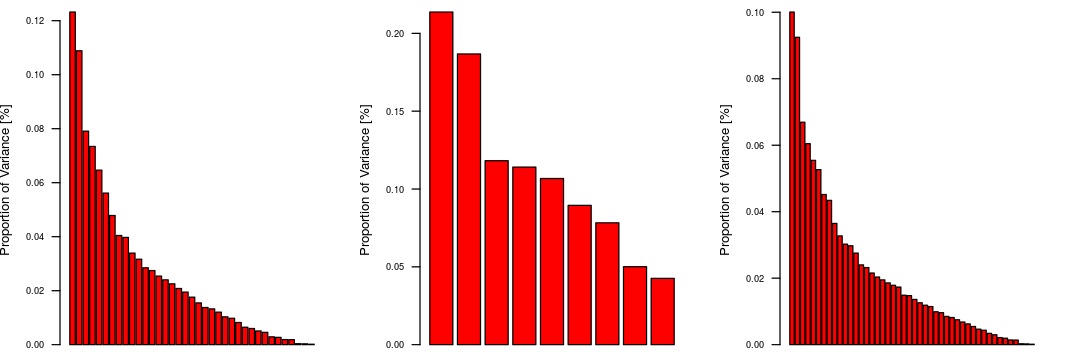

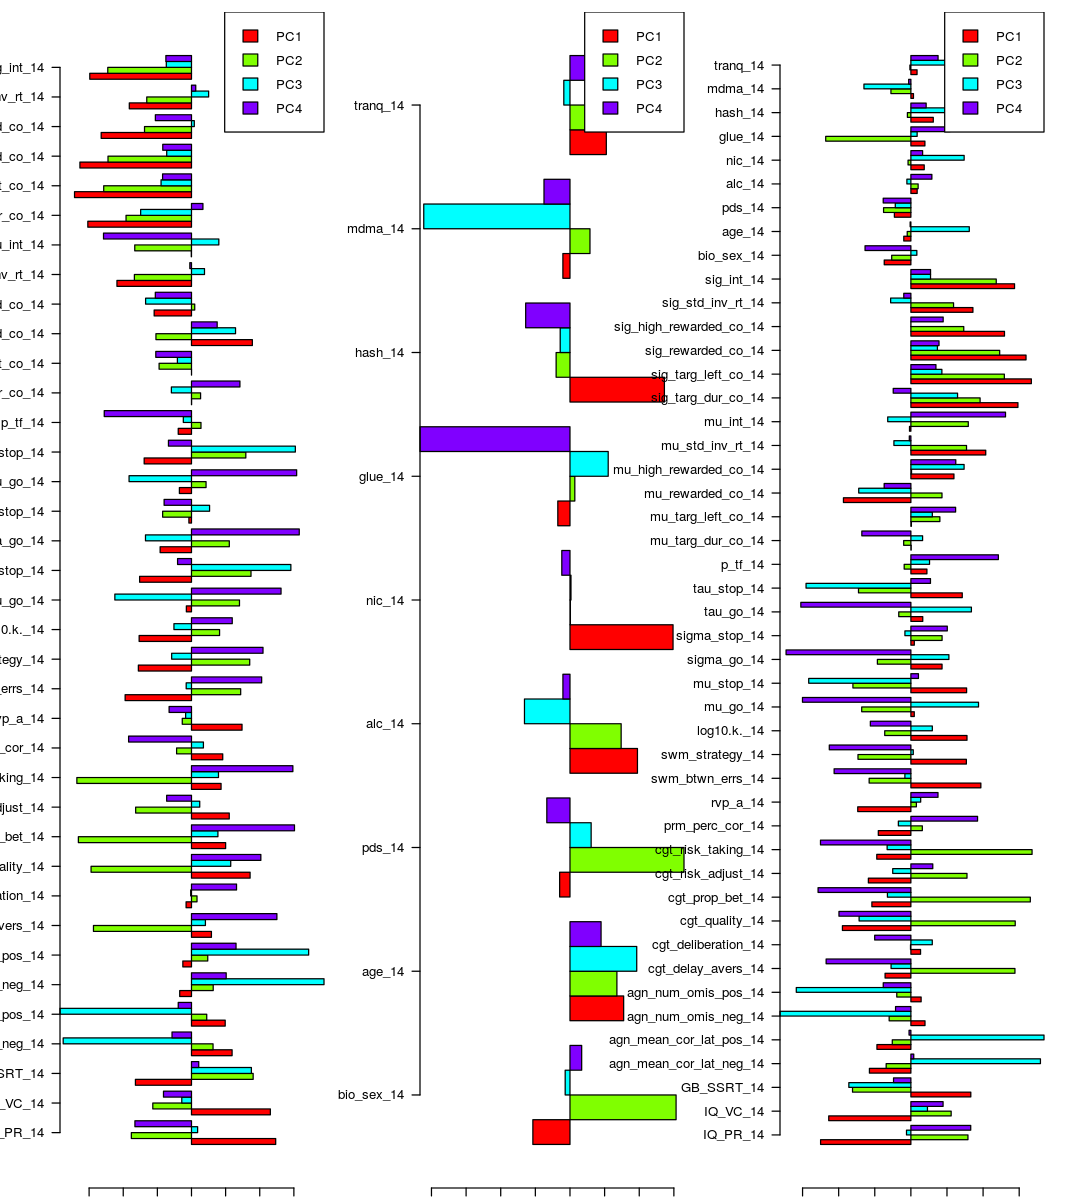

In [35]:
# Perform Task Data PCA:
task_pca      <- prcomp(data_14_task.imputed, center = TRUE, scale. = TRUE)
task_pca_pvar <- task_pca$sdev^2/sum(task_pca$sdev^2)

# Perform Survey Data PCA:
survey_pca      <- prcomp(data_14_survey.imputed, center = TRUE, scale. = TRUE)
survey_pca_pvar <- survey_pca$sdev^2/sum(survey_pca$sdev^2)

# Perform All Data PCA:
task_survey_pca      <- prcomp(imputed_df, center = TRUE, scale. = TRUE) 
task_survey_pca_pvar <- task_survey_pca$sdev^2/sum(task_survey_pca$sdev^2)


### PLOT THE VARIATION CAPTURED BY PCAs:
par(mfrow=c(1,3), mai = c(0.1, 0.5, 0.1, 0.3))
options(repr.plot.width=9, repr.plot.height=3)

ylab_top <- "Proportion of Variance [%]"

# Task PCA Plot:
barplot(task_pca_pvar,  col=c('red'), las=2, cex.axis=0.7, xlab=c('Principle Components'), ylab=ylab_top)

# Survey PCA Plot:
barplot(survey_pca_pvar,  col=c('red'), las=2, cex.axis=0.7, xlab=c('Principle Components'), ylab=ylab_top)

# Task-Survey PCA Plot: 
barplot(task_survey_pca_pvar,  col=c('red'), las=2, cex.axis=0.7, 
        xlab=c('Principle Components'), ylab=c("Proportion of Variance [%]"))


## PLOT THE LOADINGS FOR EACH PCA:
par(mfrow=c(1,3), mai = c(0.1, 0.5, 0.1, 0.3))
options(repr.plot.width=9, repr.plot.height=10)

barplot(t(task_pca$rotation[,1:4]), main="", horiz=TRUE, beside=TRUE, col=rainbow(4), yaxt='n')
axis(2, labels=colnames(data_14_task.imputed), at=seq(3,n_feat_task*5,by=5), las=2)
legend("topright", legend=c('PC1', 'PC2', 'PC3', 'PC4'), fill = rainbow(4))

barplot(t(survey_pca$rotation[,1:4]), main="", horiz=TRUE, beside=TRUE, col=rainbow(4), yaxt='n')
axis(2, labels=colnames(data_14_survey.imputed), at=seq(3,n_feat_survey*5,by=5), las=2)
legend("topright", legend=c('PC1', 'PC2', 'PC3', 'PC4'), fill = rainbow(4))

barplot(t(task_survey_pca$rotation[,1:4]), main="", horiz=TRUE, beside=TRUE, col=rainbow(4), yaxt='n')
axis(2, labels=colnames(imputed_df), at=seq(3,(n_feat_task + n_feat_survey)*5,by=5), las=2)
legend("topright", legend=c('PC1', 'PC2', 'PC3', 'PC4'), fill = rainbow(4))

## CCA Across Baseline + Follow Up ##

In [37]:
#new_df     <- imputed_df[complete.cases(imputed_df[,'X8a.life.alc_18']),]
imputed_df <- raw_df[c(features_14_task, features_14_survey)]

# Impute the task features:
imputed_df[features_14_task] <- EMalg(imputed_df[features_14_task], tol=.0001)

# Inverting a regression of alcohol and nicotine on the espad vars would be better...
# This shouldn't be too bad though.
library(splines)
library(foreach)
library(gam)


# Drop columns with all zeros, since they're uninformative.
tmp <- na.gam.replace(data_14_survey.raw)
imputed_df[features_14_survey] <- tmp[, colSums(tmp != 0) > 0]
imputed_df[features_14_survey] <- round(imputed_df[features_14_survey])

#dim(imputed_df[complete.cases(raw_df[,'X8a.life.alc_18']),])
imputed_df <- imputed_df[complete.cases(raw_df[,'X8a.life.alc_18']),]

imputed_df <- imputed_df[, colSums(imputed_df != 0) > 0]

data_18_survey.raw <- data_18_survey.raw[complete.cases(data_18_survey.raw[,'X8a.life.alc_18']),]
data_18_survey.raw <- data_18_survey.raw[, colSums(data_18_survey.raw != 0) > 0]

#data_18_survey <- data_18_survey.raw[complete.cases(data_18_survey.raw[,'X8a.life.alc_18']),]
#dim(imputed_df)
#dim(data_18_survey.raw)

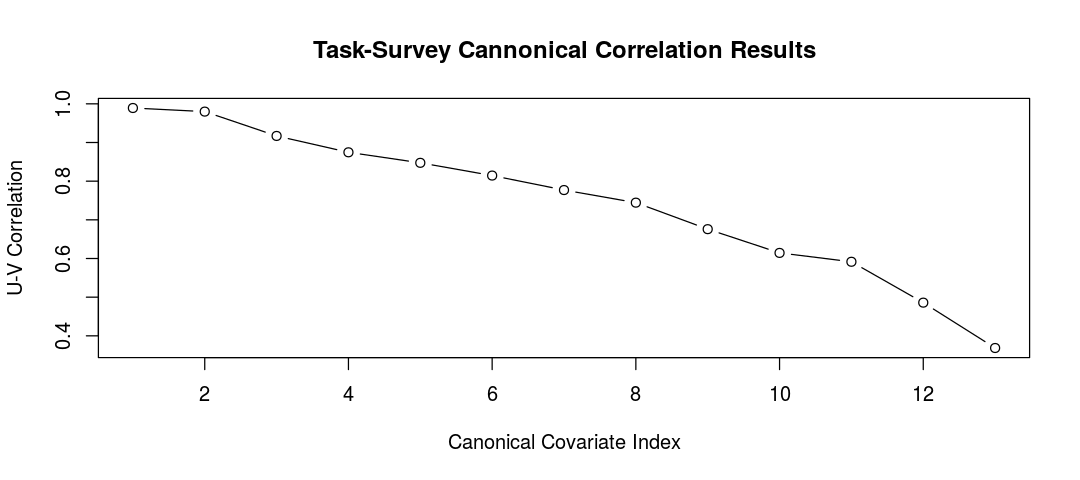

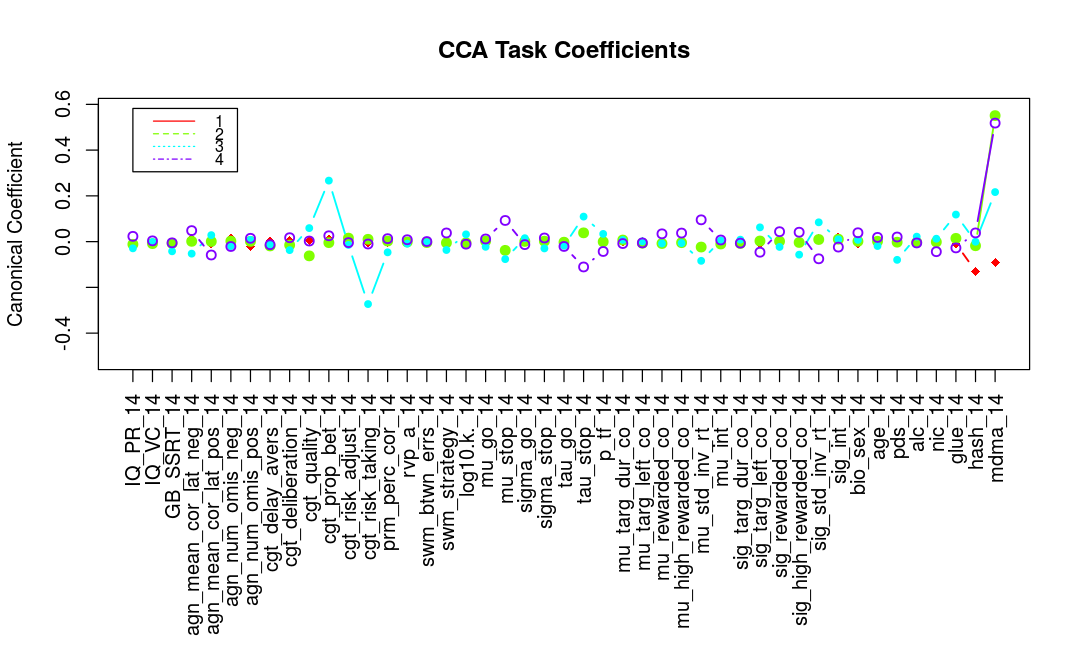

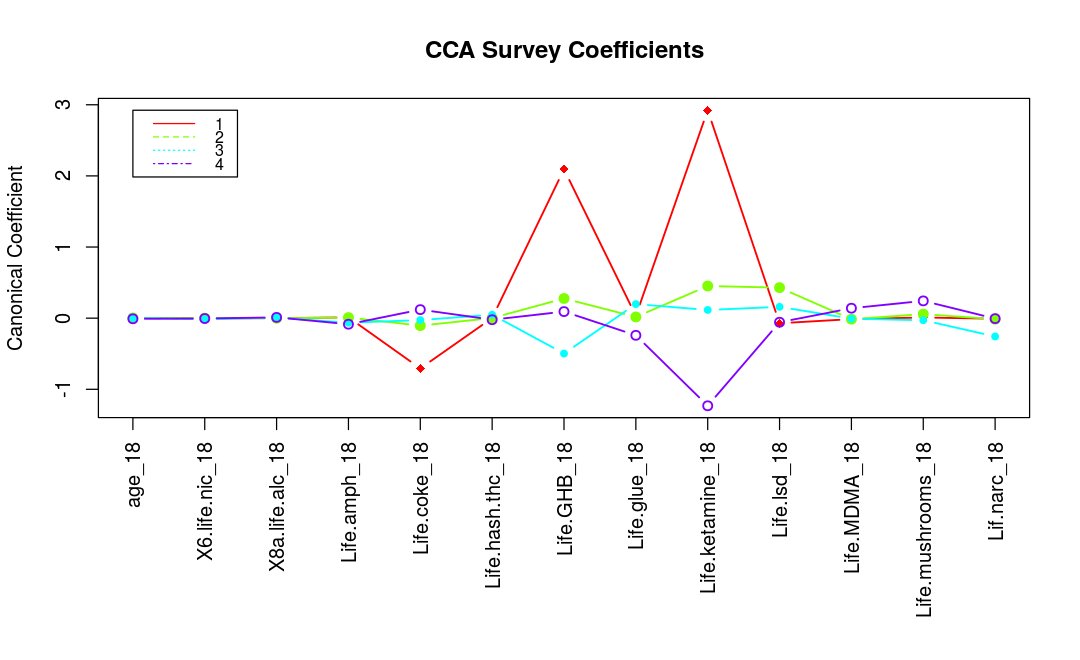

In [38]:
# Canonical Correlation Analysis:
library(CCA)
canon_corr_res <- cancor(imputed_df, data_18_survey.raw)

n_feat_task   <- length(colnames(imputed_df))
n_feat_survey <- length(colnames(data_18_survey.raw))

options(repr.plot.width=9, repr.plot.height=4)
plot(canon_corr_res$cor,type="b", main='Task-Survey Cannonical Correlation Results',
     xlab='Canonical Covariate Index', ylab='U-V Correlation')

#####
nlines <- 4
plotchar <- seq(18,18+nlines,1)

xrange <- range(1:n_feat_task) 
yrange <- range(canon_corr_res$xcoef)

op <- par(mar=c(12.1, 4.1, 4.1, 2.1))
#par(mfrow=c(2,1), mai = c(2.6, 0.5, 0.5, 0.1))
options(repr.plot.width=9, repr.plot.height=5.5)

plot(xrange, yrange, type="n", xlab="", ylab="Canonical Coefficient", xaxt="n") 

colors <- rainbow(nlines) 
linetype <- c(1:nlines) 
#plotchar <- seq(18,18+ntrees,1)

for (i in 1:nlines) { 
  lines(1:length(canon_corr_res$xcoef[,i]), canon_corr_res$xcoef[,i], type="b", lwd=1.5,
    lty=linetype[1], col=colors[i], pch=plotchar[i])
}

# add a title and subtitle 
title("CCA Task Coefficients")

# add a legend
legend(xrange[1], yrange[2], 1:nlines, cex=0.8, col=colors, lty=linetype)
axis(1, labels=colnames(imputed_df), at=1:n_feat_task, las=2)

## CCA 
nlines = 4
plotchar <- seq(18,18+nlines,1)

xrange <- range(1:n_feat_survey) 
yrange <- range(canon_corr_res$ycoef)

op <- par(mar=c(10.1, 4.1, 4.1, 2.1))

plot(xrange, yrange, type="n", xlab="", ylab="Canonical Coefficient", xaxt="n") 

colors <- rainbow(nlines) 
linetype <- c(1:nlines) 
#plotchar <- seq(18,18+ntrees,1)

for (i in 1:nlines) { 
  lines(1:length(canon_corr_res$ycoef[,i]), canon_corr_res$ycoef[,i], type="b", lwd=1.5, lty=linetype[1], col=colors[i], pch=plotchar[i])
}

# add a title and subtitle 
title("CCA Survey Coefficients")

# add a legend
legend(xrange[1], yrange[2], 1:nlines, cex=0.8, col=colors, lty=linetype)
axis(1, labels=colnames(data_18_survey.raw), at=1:n_feat_survey, las=2)

In [39]:
# Significance testing:
library(CCP)
n_obs         <- dim(imputed_df)[1]
n_task_vars   <- dim(imputed_df)[2]
n_survey_vars <- dim(data_18_survey.raw)[2]

p.asym(rho = canon_corr_res$cor, n_obs, n_task_vars, n_survey_vars, tstat = "Wilks")

Wilks' Lambda, using F-approximation (Rao's F):
                   stat    approx df1      df2      p.value
1 to 13:   7.790698e-08 2.4369263 585 527.4771 0.000000e+00
2 to 13:   3.624927e-06 1.8298394 528 496.2120 7.009837e-12
3 to 13:   9.100860e-05 1.3634695 473 463.4036 4.136109e-04
4 to 13:   5.715634e-04 1.1771570 420 429.0372 4.656797e-02
5 to 13:   2.431839e-03 1.0453885 369 393.1010 3.321778e-01
6 to 13:   8.627259e-03 0.9236366 320 355.5879 7.660556e-01
7 to 13:   2.562975e-02 0.8121836 273 316.4966 9.616676e-01
8 to 13:   6.468245e-02 0.7090415 228 275.8333 9.964118e-01
9 to 13:   1.450856e-01 0.6003076 185 233.6146 9.998423e-01
10 to 13:  2.671108e-01 0.5181736 144 189.8700 9.999791e-01
11 to 13:  4.291441e-01 0.4496927 105 144.6444 9.999892e-01
12 to 13:  6.601554e-01 0.3325803  68  98.0000 9.999983e-01
13 to 13:  8.641598e-01 0.2381718  33  50.0000 9.999815e-01


## Gaussian Mixture Model ##

In [57]:
#library(rtkore)
#library(MixAll)

#imputed_df <- merge(data_14_task.imputed,data_14_survey.imputed)

#model <- list()
#for (i in 1:5) {
#    model[[i]] <- clusterDiagGaussian(data=imputed_df, nbCluster=i, strategy = clusterFastStrategy())
#    summary(model[[i]])
#}

# Misc. Info #

## Description of the CANTAB Measures ##
Participants completed five of the CANTAB tests. 

**The Affective Go/No-go** task comprised of alternating blocks in which participants were presented with positively or negatively valenced target words embedded in a stream of neutral distracter words. Participants were instructed to respond to targets with a button press.  Measures included in the analyses were the total number of omissions to positive and negative targets, and the average response latency to positive and negative target words.
- 'agn_mean_correct_latency_negative'  Measure is average RT to negative targets
- 'agn_mean_correct_latency_positive' Measure is average RT to positive targets
- 'agn_total_omissions_negative' Measure is number of negatively valenced target words that the participant failed to respond to 
- 'agn_total_omissions_positive' Measure is number of positively valenced target words that the participant failed to respond to 

<br />
In the Pattern Recognition Memory task participants were required to remember 12 abstract patterns; the percentage of patterns correctly recognized on a two alternative forced choice task completed immediately after encoding was included in the analyses. 
- 'prm_percent_correct'  Score reflects % correct

<br />
**The Spatial Working Memory Task** required participants to “search” for a token hidden by one of a number of boxes on the monitor by selecting the boxes in sequence. Once the token is uncovered, participants must search again with the condition that the token will not be hidden in the same location more than once. The number of times participants returned to search a box that had already contained the token was entered into the analyses as an error measure. We also included a strategy score (ranging from 1-37, with lower scores indicating a more strategic approach), which reflects how often a search sequence was initiated from a novel position.
- 'swm_between_errors':  Score reflects the number of times the child revisits a box that has already been shown to contain a token (higher scores represent less efficiency).
- 'swm_strategy': For displays with more than 6 boxes, this measure represents the number of boxes in which the child initiates a new search within the same display (higher scores represent a less strategic approach).

<br />
**The Rapid Visual Information Processing** task comprised of a stream of digits presented at 1.67Hz and participants were required to monitor the stream for target sequence of three digits. We included a signal detection measure of sensitivity to the target sequence in the analyses. 
- 'rvp_a'  Score is a signal detection measure reflecting ability to discriminate a target sequence of 3 digits embedded in a rapidly presented stream.

<br />
**The Cambridge Guessing Task (CGT)** was a modified version of the Cambridge Gambling Task, renamed in order to make it appropriate to administer to adolescents.  On each trial of the CGT the participant was presented with 10 boxes, some of which are blue, some of which are red, and must “guess” which color box conceals a hidden yellow token.  Participants start the task with 100 points and lose or acquire points by wagering on their guess.  The options the participant can choose to wager are determined by the program as a proportion of their total number of points, presented in either increasing or decreasing amounts.  Measures included the time taken to select the option on which to bet, an average of the proportion of the total number of points wagered on each trial, the proportion of trials on which the more likely outcome was selected (quality of decision making), an average of the proportion wagered on trials when the participant selected the more likely result (rational bets), risk adjustment assessed by variation in the amount wagered in response to the ratio of red to blue boxes, and an index of delay aversion reflected in making higher bets when the amount to bet is presented in descending order rather than in ascending order.
- 'cgt_delay_aversion'  Delay aversion is a measure of the particicipant's preference for making higher bets when the amount to wager is presented in descending (rather than ascending) order.
- 'cgt_deliberation_time' Deliberation time is the time taken to select an amount to wager.
- 'cgt_quality_of_decision_making' Proportion of trials on which the more likely outcome was selected
- 'cgt_overall_proportion_bet' The average of the proportion of the participant's current kitty that is wagered on each trial
- 'cgt_risk_adjustment' The degree to which the proportion bet is affected by the ratio of red:blue boxes on every trial, accounting for the overall proportion bet. (N.B. This measure is not available at baseline for 1 site)
- 'cgt_risk_taking' The average of the proportion of the participant's current kitty that is wagered on each trial, but only for those trials on which they selected the more likely option.